In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords, wordnet
import seaborn as sns
import contractions
import re
import string
from nltk.tokenize import word_tokenize
from collections import Counter
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot
from nltk.probability import FreqDist
from palettable.colorbrewer.qualitative import Pastel1_7
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# pip install wordcloud
# pip install nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

In [3]:
#loading the dataset

tweet_df = train = pd.read_csv('train.csv')
df = tweet_df

In [4]:
tweet_df.shape

(27481, 4)

In [5]:
tweet_df

textID                                               text  \
0      cb774db0d1                I`d have responded, if I were going   
1      549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2      088c60f138                          my boss is bullying me...   
3      9642c003ef                     what interview! leave me alone   
4      358bd9e861   Sons of ****, why couldn`t they put them on t...   
...           ...                                                ...   
27476  4eac33d1c0   wish we could come see u on Denver  husband l...   
27477  4f4c4fc327   I`ve wondered about rake to.  The client has ...   
27478  f67aae2310   Yay good for both of you. Enjoy the break - y...   
27479  ed167662a5                         But it was worth it  ****.   
27480  6f7127d9d7     All this flirting going on - The ATG smiles...   

                                           selected_text sentiment  
0                    I`d have responded, if I were going   neutral  
1                                               Sooo SAD  negative  
2                                            bullying me  negative  
3                                         leave me alone  negative  
4                                          Sons of ****,  negative  
...                                                  ...       ...  
27476                                             d lost  negative  
27477                                      , don`t force  negative  
27478                          Yay good for both of you.  positive  
27479                         But it was worth it  ****.  positive  
27480  All this flirting going on - The ATG smiles. Y...   neutral  

[27481 rows x 4 columns]

In [6]:
print(tweet_df.shape)

(27481, 4)


In [7]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [8]:
#Checking for null values
null_val= tweet_df.isna().sum()
null_val


textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

<AxesSubplot:xlabel='Feature', ylabel='MissingCount'>

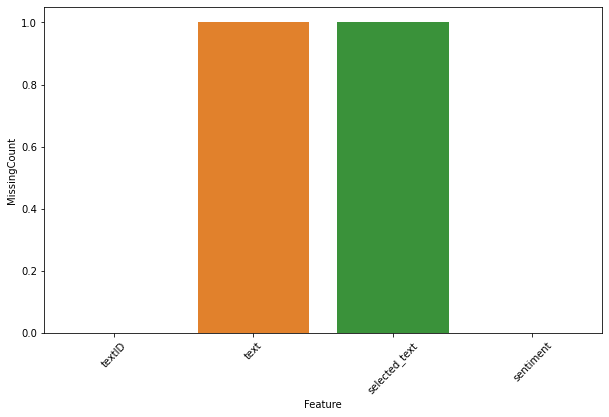

In [9]:
#Plotting the count of nulls in each column
null_val = pd.DataFrame(null_val)
null_val.reset_index(inplace = True)
null_val.columns = ["Feature","MissingCount"]
plt.figure(figsize = (10,6))
plt.xticks(rotation=46)
sns.barplot(x = "Feature",y ="MissingCount",data = null_val)

In [10]:
#dropping selected_text column
tweet_df.drop('selected_text', axis=1, inplace=True)
tweet_df.head()

textID                                               text sentiment
0  cb774db0d1                I`d have responded, if I were going   neutral
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!  negative
2  088c60f138                          my boss is bullying me...  negative
3  9642c003ef                     what interview! leave me alone  negative
4  358bd9e861   Sons of ****, why couldn`t they put them on t...  negative

In [11]:
#printing the missing value
tweet_df[tweet_df.isna().any(axis=1)]

textID text sentiment
314  fdb77c3752  NaN   neutral

In [12]:
#replacing the missing value
# text has only 1 missing value with neutral sentiment, lets replace the null with a neural statement
tweet_df["text"].fillna("It's interesting", inplace = True)
tweet_df.isna().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [13]:
# Sentiment Distribution
tweet=train['sentiment'].value_counts()
tweet

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64

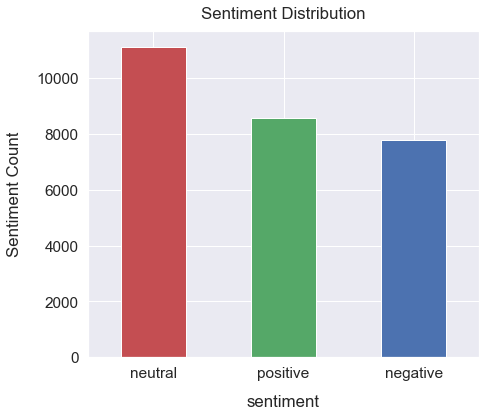

In [14]:
# Distribution plots based on sentiment
sns.set(font_scale=1.4)
tweet_df['sentiment'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0, color=["r", "g", "b"])

plt.xlabel("sentiment", labelpad=14)
plt.ylabel("Sentiment Count", labelpad=14)
plt.title("Sentiment Distribution", y=1.02);


In [15]:
tweet.plot.pie(
    labels=["neutral", "positive", "negative"],
    colors=["r", "g", "b"],
    autopct="%.2f",
    fontsize=20,
    figsize=(6, 6),
)

<AxesSubplot:ylabel='sentiment'>

In [16]:
#most frequently used words
tweet_df['freq_words'] = tweet_df['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in tweet_df['freq_words'] for item in sublist])
tweety= pd.DataFrame(top.most_common(10))
tweety.columns = ['freq_words','Word_count']
tweety.style.background_gradient(cmap='Oranges')

# Data Pre-Processing 

### Standardization

In [17]:
#standardization on Text - converting all the data to lowercase
tweet_df["text_lowerCase"] = tweet_df["text"].apply(lambda t: t.lower())

### Contraction Removal

In [18]:
#Removing text Contractions
#many of the words have contractions in them, removing contractions helps in text standardization
tweet_df['no_txt_contrac'] = tweet_df['text_lowerCase'].apply(lambda t: ' '.join([contractions.fix(word) for word in str(t).replace('`', '\'').split()]))

In [19]:
#Cleaning the data by removing square breackets, http, url, special characters, punctuations and text/words containg numbers 

def tweet_df_clean(no_txt_contrac):
    no_txt_contrac = re.sub('\[.*?\]', '', no_txt_contrac) #square brackets
    no_txt_contrac = re.sub('https?://\S+|www\.\S+', '', no_txt_contrac) #https
    no_txt_contrac = re.sub('<.*?>+', '', no_txt_contrac) #special char
    no_txt_contrac = re.sub('[%s]' % re.escape(string.punctuation), '', no_txt_contrac) #punctuations
    no_txt_contrac = re.sub('\n', '', no_txt_contrac) #spaces
    no_txt_contrac = re.sub('\w*\d\w*', '', no_txt_contrac) #words/sentances with numbers    
    
    return no_txt_contrac
#printing the cleaned data
tweet_df['Clean_text'] = tweet_df['no_txt_contrac'].apply(lambda t:tweet_df_clean(t))
tweet_df.head(4)

textID                                            text sentiment  \
0  cb774db0d1             I`d have responded, if I were going   neutral   
1  549e992a42   Sooo SAD I will miss you here in San Diego!!!  negative   
2  088c60f138                       my boss is bullying me...  negative   
3  9642c003ef                  what interview! leave me alone  negative   

                                          freq_words  \
0        [I`d, have, responded,, if, I, were, going]   
1  [Sooo, SAD, I, will, miss, you, here, in, San,...   
2                    [my, boss, is, bullying, me...]   
3               [what, interview!, leave, me, alone]   

                                   text_lowerCase  \
0             i`d have responded, if i were going   
1   sooo sad i will miss you here in san diego!!!   
2                       my boss is bullying me...   
3                  what interview! leave me alone   

                                  no_txt_contrac  \
0        i would have responded, if i were going   
1  sooo sad i will miss you here in san diego!!!   
2                      my boss is bullying me...   
3                 what interview! leave me alone   

                                   Clean_text  
0      i would have responded if i were going  
1  sooo sad i will miss you here in san diego  
2                      my boss is bullying me  
3               what interview leave me alone

### Tokenization

In [20]:
#tokenizing the text
#In order for this sentence to be understood by a machine, tokenization is performed on the string to break it into individual parts
tweet_df['tokenized_text'] = tweet_df['Clean_text'].apply(word_tokenize)
tweet_df.head(4)

textID                                            text sentiment  \
0  cb774db0d1             I`d have responded, if I were going   neutral   
1  549e992a42   Sooo SAD I will miss you here in San Diego!!!  negative   
2  088c60f138                       my boss is bullying me...  negative   
3  9642c003ef                  what interview! leave me alone  negative   

                                          freq_words  \
0        [I`d, have, responded,, if, I, were, going]   
1  [Sooo, SAD, I, will, miss, you, here, in, San,...   
2                    [my, boss, is, bullying, me...]   
3               [what, interview!, leave, me, alone]   

                                   text_lowerCase  \
0             i`d have responded, if i were going   
1   sooo sad i will miss you here in san diego!!!   
2                       my boss is bullying me...   
3                  what interview! leave me alone   

                                  no_txt_contrac  \
0        i would have responded, if i were going   
1  sooo sad i will miss you here in san diego!!!   
2                      my boss is bullying me...   
3                 what interview! leave me alone   

                                   Clean_text  \
0      i would have responded if i were going   
1  sooo sad i will miss you here in san diego   
2                      my boss is bullying me   
3               what interview leave me alone   

                                      tokenized_text  
0    [i, would, have, responded, if, i, were, going]  
1  [sooo, sad, i, will, miss, you, here, in, san,...  
2                       [my, boss, is, bullying, me]  
3                [what, interview, leave, me, alone]

### Stopwords Removal

In [21]:
#Removing Stopword from text
#Stopwords are the commonly used words that they carry very little useful information
stop = set(stopwords.words('english'))
tweet_df['stopwords'] = tweet_df['tokenized_text'].apply(lambda t: [word for word in t if word not in stop])
tweet_df.head(4)

textID                                            text sentiment  \
0  cb774db0d1             I`d have responded, if I were going   neutral   
1  549e992a42   Sooo SAD I will miss you here in San Diego!!!  negative   
2  088c60f138                       my boss is bullying me...  negative   
3  9642c003ef                  what interview! leave me alone  negative   

                                          freq_words  \
0        [I`d, have, responded,, if, I, were, going]   
1  [Sooo, SAD, I, will, miss, you, here, in, San,...   
2                    [my, boss, is, bullying, me...]   
3               [what, interview!, leave, me, alone]   

                                   text_lowerCase  \
0             i`d have responded, if i were going   
1   sooo sad i will miss you here in san diego!!!   
2                       my boss is bullying me...   
3                  what interview! leave me alone   

                                  no_txt_contrac  \
0        i would have responded, if i were going   
1  sooo sad i will miss you here in san diego!!!   
2                      my boss is bullying me...   
3                 what interview! leave me alone   

                                   Clean_text  \
0      i would have responded if i were going   
1  sooo sad i will miss you here in san diego   
2                      my boss is bullying me   
3               what interview leave me alone   

                                      tokenized_text  \
0    [i, would, have, responded, if, i, were, going]   
1  [sooo, sad, i, will, miss, you, here, in, san,...   
2                       [my, boss, is, bullying, me]   
3                [what, interview, leave, me, alone]   

                       stopwords  
0      [would, responded, going]  
1  [sooo, sad, miss, san, diego]  
2               [boss, bullying]  
3      [interview, leave, alone]

### Parts-of-Speech Tagging

In [22]:
# After we have tokenized and removed stop words 
#Lets add POS(Parts of speeech) tagging to each word
tweet_df['Tagging'] = tweet_df['stopwords'].apply(lambda t: nltk.tag.pos_tag(t))

# now converting them to adjective, verb, noun and adverb
def get_Tagging(Tagging):
    if Tagging.startswith('J'):
        return wordnet.ADJ
    elif Tagging.startswith('V'):
        return wordnet.VERB
    elif Tagging.startswith('N'):
        return wordnet.NOUN
    elif Tagging.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

    
tweet_df['Tagging'] = tweet_df['Tagging'].apply(lambda x: [(word, get_Tagging(Tagging)) 
                                                               for (word, Tagging) in x])
tweet_df.head(4)

textID                                            text sentiment  \
0  cb774db0d1             I`d have responded, if I were going   neutral   
1  549e992a42   Sooo SAD I will miss you here in San Diego!!!  negative   
2  088c60f138                       my boss is bullying me...  negative   
3  9642c003ef                  what interview! leave me alone  negative   

                                          freq_words  \
0        [I`d, have, responded,, if, I, were, going]   
1  [Sooo, SAD, I, will, miss, you, here, in, San,...   
2                    [my, boss, is, bullying, me...]   
3               [what, interview!, leave, me, alone]   

                                   text_lowerCase  \
0             i`d have responded, if i were going   
1   sooo sad i will miss you here in san diego!!!   
2                       my boss is bullying me...   
3                  what interview! leave me alone   

                                  no_txt_contrac  \
0        i would have responded, if i were going   
1  sooo sad i will miss you here in san diego!!!   
2                      my boss is bullying me...   
3                 what interview! leave me alone   

                                   Clean_text  \
0      i would have responded if i were going   
1  sooo sad i will miss you here in san diego   
2                      my boss is bullying me   
3               what interview leave me alone   

                                      tokenized_text  \
0    [i, would, have, responded, if, i, were, going]   
1  [sooo, sad, i, will, miss, you, here, in, san,...   
2                       [my, boss, is, bullying, me]   
3                [what, interview, leave, me, alone]   

                       stopwords  \
0      [would, responded, going]   
1  [sooo, sad, miss, san, diego]   
2               [boss, bullying]   
3      [interview, leave, alone]   

                                             Tagging  
0           [(would, n), (responded, v), (going, v)]  
1  [(sooo, a), (sad, a), (miss, n), (san, n), (di...  
2                         [(boss, n), (bullying, v)]  
3           [(interview, n), (leave, v), (alone, r)]

### Lemmatization

In [23]:
#converting a word to its meaningful base or root form by Lemmatization
from nltk.stem import WordNetLemmatizer
lm = nltk.WordNetLemmatizer()
tweet_df['lemmatization'] = tweet_df['Tagging'].apply(lambda m:[lm.lemmatize(w,t) for w ,t in m])

tweet_df.head()

textID                                               text sentiment  \
0  cb774db0d1                I`d have responded, if I were going   neutral   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!  negative   
2  088c60f138                          my boss is bullying me...  negative   
3  9642c003ef                     what interview! leave me alone  negative   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...  negative   

                                          freq_words  \
0        [I`d, have, responded,, if, I, were, going]   
1  [Sooo, SAD, I, will, miss, you, here, in, San,...   
2                    [my, boss, is, bullying, me...]   
3               [what, interview!, leave, me, alone]   
4  [Sons, of, ****,, why, couldn`t, they, put, th...   

                                      text_lowerCase  \
0                i`d have responded, if i were going   
1      sooo sad i will miss you here in san diego!!!   
2                          my boss is bullying me...   
3                     what interview! leave me alone   
4   sons of ****, why couldn`t they put them on t...   

                                      no_txt_contrac  \
0            i would have responded, if i were going   
1      sooo sad i will miss you here in san diego!!!   
2                          my boss is bullying me...   
3                     what interview! leave me alone   
4  sons of ****, why could not they put them on t...   

                                          Clean_text  \
0             i would have responded if i were going   
1         sooo sad i will miss you here in san diego   
2                             my boss is bullying me   
3                      what interview leave me alone   
4  sons of  why could not they put them on the re...   

                                      tokenized_text  \
0    [i, would, have, responded, if, i, were, going]   
1  [sooo, sad, i, will, miss, you, here, in, san,...   
2                       [my, boss, is, bullying, me]   
3                [what, interview, leave, me, alone]   
4  [sons, of, why, could, not, they, put, them, o...   

                                       stopwords  \
0                      [would, responded, going]   
1                  [sooo, sad, miss, san, diego]   
2                               [boss, bullying]   
3                      [interview, leave, alone]   
4  [sons, could, put, releases, already, bought]   

                                             Tagging  \
0           [(would, n), (responded, v), (going, v)]   
1  [(sooo, a), (sad, a), (miss, n), (san, n), (di...   
2                         [(boss, n), (bullying, v)]   
3           [(interview, n), (leave, v), (alone, r)]   
4  [(sons, n), (could, n), (put, v), (releases, n...   

                              lemmatization  
0                      [would, respond, go]  
1             [sooo, sad, miss, san, diego]  
2                              [bos, bully]  
3                 [interview, leave, alone]  
4  [son, could, put, release, already, buy]

## Let us analyze our texts:

### Finding Text Length & Word frequency


In [24]:
# using Clean_text for creating new columns ie. text_length and word_count
tweet_df['text_length'] = tweet_df['Clean_text'].astype(str).apply(len)
tweet_df['word_count'] = tweet_df['Clean_text'].apply(lambda t : len(str(t).split()))

In [25]:
tweet_df['freq_words'] = tweet_df['lemmatization']

In [26]:
# creating 3 different dataframes based on our sentiment
Pos_sent = tweet_df[tweet_df['sentiment'] == 'positive']
Neg_sent = tweet_df[tweet_df['sentiment'] == 'negative']
Neu_sent = tweet_df[tweet_df['sentiment'] == 'neutral']

### Text Length Analysis

In [27]:
#Sentiment wise text length distribution
pos = go.Violin(
    y=Pos_sent['text_length'],
    name = 'Positive tweet',
    marker = dict(
        color = 'green',
    )
)

neg = go.Violin(
    y=Neg_sent['text_length'],
    name = 'Negative tweet',
    marker = dict(
        color = 'red',
    )
)

neu = go.Violin(
    y=Neu_sent['text_length'],
    name = 'Neutral tweet',
    marker = dict(
        color = 'orange',
    )
)
list = [pos, neg, neu]
layout = go.Layout(
    title = "Sentiment wise text length"
)

length_of_text = go.Figure(data=list,layout=layout)
iplot(length_of_text, filename = "Sentiment wise text length")

### Word Count Analysis

In [28]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(Pos_sent['word_count'], shade=True, color="r").set_title('Word Count Distribution')
p1=sns.kdeplot(Neg_sent['word_count'], shade=True, color="b")
p1=sns.kdeplot(Neu_sent['word_count'], shade=True, color="g")
plt.legend(labels =["Positive","Negative","Neutral"])

### Most Frequent Words In Each Sentiment

##### Positive

In [29]:
#most common or frequent word in positive sentiments
pos_itive = Counter([item for sublist in Pos_sent['freq_words'] for item in sublist])
words_positive = pd.DataFrame(pos_itive.most_common(20))
words_positive.columns = ['Frequent_words','word_count']
pos_itive_w = px.treemap(words_positive, path=['Frequent_words'], values='word_count',title='Most Frequent Positive Words')
pos_itive_w.show()

##### Negative

In [30]:
#most common or frequent word in Negative sentiments
neg_itive = Counter([item for sublist in Neg_sent['freq_words'] for item in sublist])
words_negative = pd.DataFrame(neg_itive.most_common(20))
words_negative.columns = ['Frequent_words','word_count']
Negative_chart= px.bar(words_negative, x="word_count", y="Frequent_words", title='Frequent Negative Words', orientation='h', 
             width=700, height=700,color='Frequent_words')
Negative_chart.show()

##### Neutral

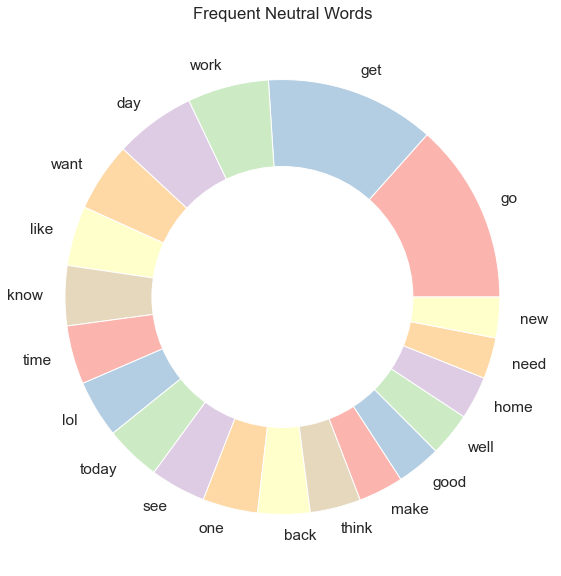

In [31]:
#most common or frequent word in neutral sentiments
Neu_tral = Counter([item for sublist in Neu_sent['freq_words'] for item in sublist])
words_neutral = pd.DataFrame(Neu_tral.most_common(20))
words_neutral.columns = ['Frequent_words','word_count']
plt.figure(figsize=(18,10))
my_donut=plt.Circle((0,0), 0.6, color='white')
plt.pie(words_neutral['word_count'], labels=words_neutral.Frequent_words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_donut)
plt.title('Frequent Neutral Words')
plt.show()

### Word Cloud For Tweets Based On Sentiments

##### Word Cloud for Positive Tweets

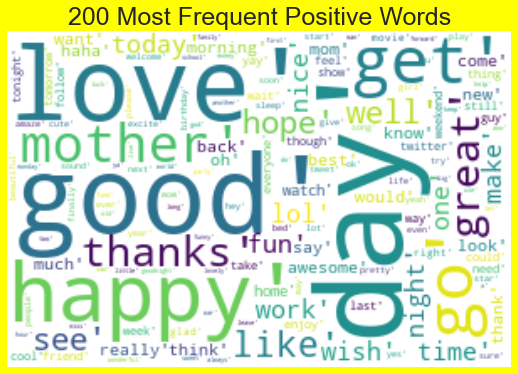

In [32]:
#positive tweets Wordcloud
words = []
for w in Pos_sent['lemmatization'].values:
    words+=w
mostcommon = FreqDist(words).most_common(200)

wordcloud = WordCloud(width=300, height=200, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(10,5), facecolor='yellow')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('200 Most Frequent Positive Words', fontsize=25)
plt.tight_layout(pad=0)
plt.show()

##### Word Cloud for Negative Tweets

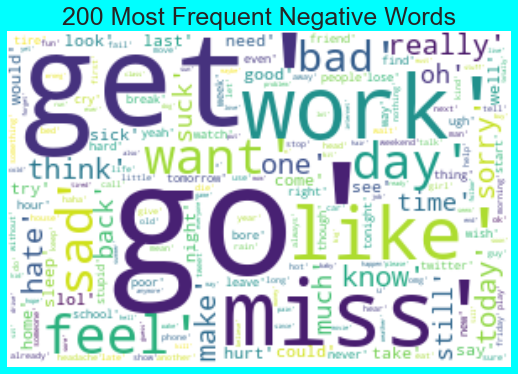

In [33]:
#Negative tweets Wordcloud
words = []
for w in Neg_sent['lemmatization'].values:
    words+=w
mostcommon = FreqDist(words).most_common(200)

wordcloud = WordCloud(width=300, height=200, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(10,5), facecolor='cyan')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('200 Most Frequent Negative Words', fontsize=25)
plt.tight_layout(pad=0)
plt.show()

##### Word Cloud for Neutral Tweets

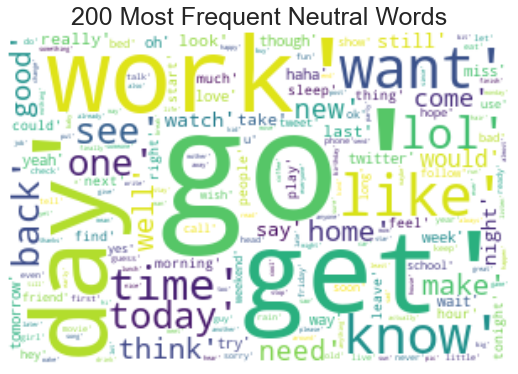

In [34]:
#Neutral tweets Wordcloud
words = []
for w in Neu_sent['lemmatization'].values:
    words+=w
mostcommon = FreqDist(words).most_common(200)

wordcloud = WordCloud(width=300, height=200, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(10,5), facecolor='White')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('200 Most Frequent Neutral Words', fontsize=25)
plt.tight_layout(pad=0)
plt.show()

### Unique Words

Text(0.5, 0.98, 'Unique words based on Sentiment')

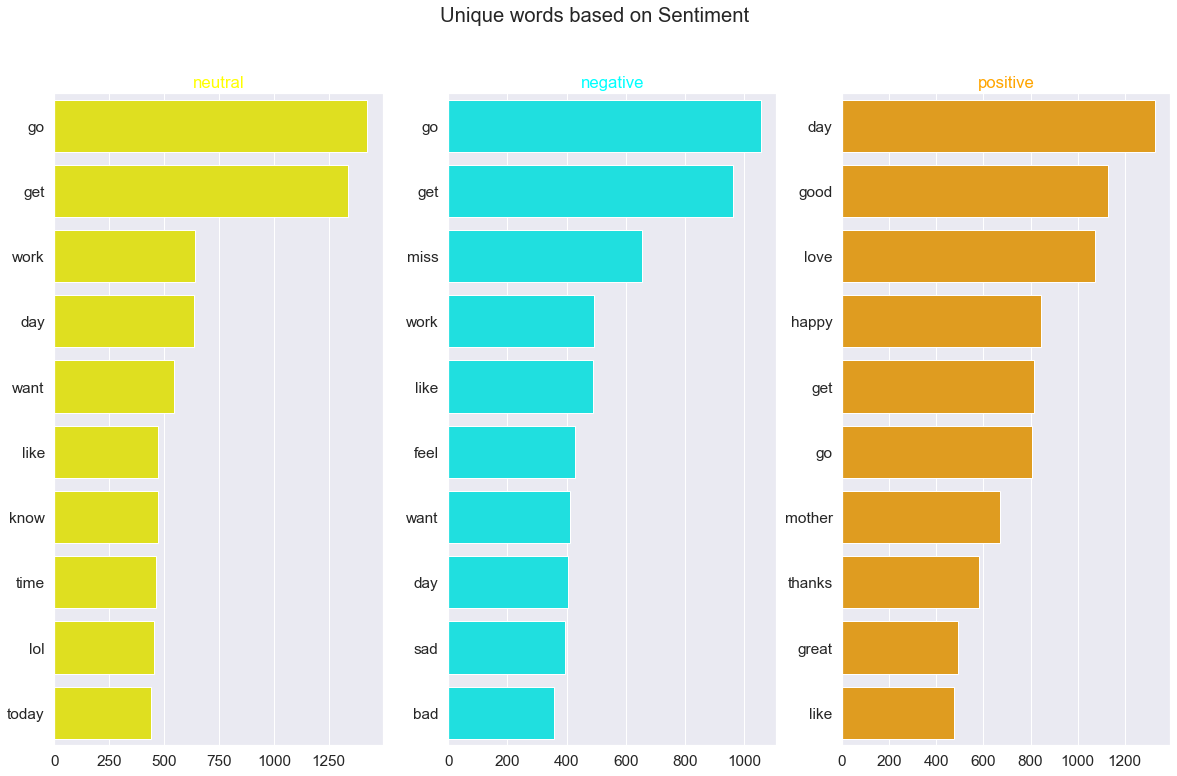

In [35]:
sent=tweet_df.sentiment.unique()
colors=['yellow','cyan','orange']
fig,ax=plt.subplots(1,3,figsize=(20,12))
for i in range(3):
    unique_words=tweet_df[tweet_df['sentiment']==sent[i]]['lemmatization']
    uni_word=[p for pun in unique_words.values for p in pun]
    counter=Counter(uni_word).most_common(10)
    x=[]
    y=[]
    for word,count in counter[:20]:
        if (word not in stop) :
            x.append(word)
            y.append(count)
    sns.barplot(x=y,y=x,ax=ax[i],color=colors[i])
    ax[i].set_title(sent[i],color=colors[i])
fig.suptitle("Unique words based on Sentiment")

In [36]:
tweet_df['lemm_Join'] = tweet_df['lemmatization'].apply(lambda l: ' '.join(l))
tweet_df.head(4)

textID                                            text sentiment  \
0  cb774db0d1             I`d have responded, if I were going   neutral   
1  549e992a42   Sooo SAD I will miss you here in San Diego!!!  negative   
2  088c60f138                       my boss is bullying me...  negative   
3  9642c003ef                  what interview! leave me alone  negative   

                      freq_words  \
0           [would, respond, go]   
1  [sooo, sad, miss, san, diego]   
2                   [bos, bully]   
3      [interview, leave, alone]   

                                   text_lowerCase  \
0             i`d have responded, if i were going   
1   sooo sad i will miss you here in san diego!!!   
2                       my boss is bullying me...   
3                  what interview! leave me alone   

                                  no_txt_contrac  \
0        i would have responded, if i were going   
1  sooo sad i will miss you here in san diego!!!   
2                      my boss is bullying me...   
3                 what interview! leave me alone   

                                   Clean_text  \
0      i would have responded if i were going   
1  sooo sad i will miss you here in san diego   
2                      my boss is bullying me   
3               what interview leave me alone   

                                      tokenized_text  \
0    [i, would, have, responded, if, i, were, going]   
1  [sooo, sad, i, will, miss, you, here, in, san,...   
2                       [my, boss, is, bullying, me]   
3                [what, interview, leave, me, alone]   

                       stopwords  \
0      [would, responded, going]   
1  [sooo, sad, miss, san, diego]   
2               [boss, bullying]   
3      [interview, leave, alone]   

                                             Tagging  \
0           [(would, n), (responded, v), (going, v)]   
1  [(sooo, a), (sad, a), (miss, n), (san, n), (di...   
2                         [(boss, n), (bullying, v)]   
3           [(interview, n), (leave, v), (alone, r)]   

                   lemmatization  text_length  word_count  \
0           [would, respond, go]           38           8   
1  [sooo, sad, miss, san, diego]           42          10   
2                   [bos, bully]           22           5   
3      [interview, leave, alone]           29           5   

                 lemm_Join  
0         would respond go  
1  sooo sad miss san diego  
2                bos bully  
3    interview leave alone

#### Pre-Processing for Modelling

In [37]:
tweet_df.head(3)

textID                                            text sentiment  \
0  cb774db0d1             I`d have responded, if I were going   neutral   
1  549e992a42   Sooo SAD I will miss you here in San Diego!!!  negative   
2  088c60f138                       my boss is bullying me...  negative   

                      freq_words  \
0           [would, respond, go]   
1  [sooo, sad, miss, san, diego]   
2                   [bos, bully]   

                                   text_lowerCase  \
0             i`d have responded, if i were going   
1   sooo sad i will miss you here in san diego!!!   
2                       my boss is bullying me...   

                                  no_txt_contrac  \
0        i would have responded, if i were going   
1  sooo sad i will miss you here in san diego!!!   
2                      my boss is bullying me...   

                                   Clean_text  \
0      i would have responded if i were going   
1  sooo sad i will miss you here in san diego   
2                      my boss is bullying me   

                                      tokenized_text  \
0    [i, would, have, responded, if, i, were, going]   
1  [sooo, sad, i, will, miss, you, here, in, san,...   
2                       [my, boss, is, bullying, me]   

                       stopwords  \
0      [would, responded, going]   
1  [sooo, sad, miss, san, diego]   
2               [boss, bullying]   

                                             Tagging  \
0           [(would, n), (responded, v), (going, v)]   
1  [(sooo, a), (sad, a), (miss, n), (san, n), (di...   
2                         [(boss, n), (bullying, v)]   

                   lemmatization  text_length  word_count  \
0           [would, respond, go]           38           8   
1  [sooo, sad, miss, san, diego]           42          10   
2                   [bos, bully]           22           5   

                 lemm_Join  
0         would respond go  
1  sooo sad miss san diego  
2                bos bully

In [38]:
del_cols_list = ['textID', 'freq_words', 'text_lowerCase','no_txt_contrac','text','stopwords'\
                 ,'Tagging','lemmatization','text_length','word_count','lemm_Join','Clean_text']
df2 = tweet_df.drop(columns = del_cols_list)
df2.head()

sentiment                                     tokenized_text
0   neutral    [i, would, have, responded, if, i, were, going]
1  negative  [sooo, sad, i, will, miss, you, here, in, san,...
2  negative                       [my, boss, is, bullying, me]
3  negative                [what, interview, leave, me, alone]
4  negative  [sons, of, why, could, not, they, put, them, o...

In [39]:
X = df2['tokenized_text']

X.head()

0      [i, would, have, responded, if, i, were, going]
1    [sooo, sad, i, will, miss, you, here, in, san,...
2                         [my, boss, is, bullying, me]
3                  [what, interview, leave, me, alone]
4    [sons, of, why, could, not, they, put, them, o...
Name: tokenized_text, dtype: object

In [40]:
#Encoding target labels of 'Sentiment'
from sklearn.preprocessing import LabelEncoder
l = LabelEncoder()
Y = l.fit_transform(df2['sentiment'])

In [41]:
print(X[9])
print(Y[9])
#'2' indicates its a positive sentiment

['journey', 'wow', 'you', 'just', 'became', 'cooler', 'hehe', 'is', 'that', 'possible']
2


## Building Model

### Model 1: LSTM using Neural Networks

In [42]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df2['tokenized_text'][0])
X, tokenizer = tokenize_pad_sequences(df2['tokenized_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 ['i', 'would', 'have', 'responded', 'if', 'i', 'were', 'going']
After Tokenization & Padding 
 [  1  68  14  67   1 133  32   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [43]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [44]:
from sklearn.model_selection import train_test_split
y = pd.get_dummies(df2['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer
# #from sklearn.feature_extraction.text import TfidfVectorizer

# vocabulary_size = 5000

# # Tweets have already been preprocessed hence dummy function will be passed in 
# # to preprocessor & tokenizer step
# count_vector = CountVectorizer(max_features=vocabulary_size,
# #                               ngram_range=(1,2),    # unigram and bigram
#                                 preprocessor=lambda x: x,
#                                tokenizer=lambda x: x) 
# #tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# # Fit the training data
# X_train = count_vector.fit_transform(X_train).toarray()

# # Transform testing data
# X_test = count_vector.transform(X_test).toarray()

In [ ]:
# import sklearn.preprocessing as pr

# # Normalize BoW features in training and test set
# X_train = pr.normalize(X_train, axis=1)
# X_test  = pr.normalize(X_test, axis=1)

In [45]:
X_test

array([[ 305,   16,  200, ...,    0,    0,    0],
       [ 503,  577,   84, ...,    0,    0,    0],
       [1239,  108,   29, ...,    0,    0,    0],
       ...,
       [ 914,   22,    3, ...,    0,    0,    0],
       [   1,   44,    9, ...,    0,    0,    0],
       [2866,   52,   74, ...,    0,    0,    0]])

In [46]:
print(count_vector.get_feature_names()[0:200])

NameError: name 'count_vector' is not defined

In [47]:
print("Shape of Train Set: ", X_train.shape,y_train.shape )
print("Shape of Validation Set: ", X_val.shape,y_val.shape )
print("Shape of Test Set: ", X_test.shape, y_test.shape)

Shape of Train Set:  (16488, 50) (16488, 3)
Shape of Validation Set:  (5496, 50) (5496, 3)
Shape of Test Set:  (5497, 50) (5497, 3)


In [48]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [49]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=50))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

In [50]:
# pip install -U numpy==1.18.5

In [51]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 179,939
Trainable params: 179,939
Non-trainable params: 0
__________________________________________________

In [52]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.6815
Precision : 0.6907
Recall    : 0.6545
F1 Score  : 0.6721
